<a href="https://colab.research.google.com/github/CristianCosci/Generative_Adversarial_Networks_GAN__Overview/blob/master/DCGAN/notebooks/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
from torchvision.utils import make_grid

import numpy as np
import datetime
import os, sys

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

from tqdm import tqdm
import glob
from PIL import Image

import cv2

### **Google Drive linking and other operations for saving some data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
PATH_DRIVE = '/content/drive/My Drive/UNIMORE/DCGAN' # Path on Google Drive where to save data (trained models and generation samples)

Mounted at /content/drive


In [13]:
torch.cuda.is_available()

False

In [3]:
verbose = False
torch.manual_seed(1)
NOISE_VECTOR_DIM = 100
MODEL_NAME = 'DeepConvolutionalGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not os.path.exists(PATH_DRIVE + '/samples'):
  os.makedirs(PATH_DRIVE + '/samples')

if not os.path.exists(PATH_DRIVE + '/samples/gif_dir'):
  os.makedirs(PATH_DRIVE + '/samples/gif_dir')

if not os.path.exists(PATH_DRIVE + '/training_models'):
  os.makedirs(PATH_DRIVE + '/training_models')

if not os.path.exists(PATH_DRIVE + '/training_models/Discriminator'):
  os.makedirs(PATH_DRIVE + '/training_models/Discriminator')

if not os.path.exists(PATH_DRIVE + '/training_models/Generator'):
  os.makedirs(PATH_DRIVE + '/training_models/Generator')

if not os.path.exists('dataset'):
  os.makedirs('dataset')

In [ ]:
dataset_path = PATH_DRIVE + "/anime_dataset/archive.zip"
print(dataset_path)
!unzip '/content/drive/My Drive/UNIMORE/DCGAN/anime_dataset/archive.zip' -d 'dataset/'  #unzipping dataset

# **Project start**

In [5]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [70]:
z = torch.randn(25, NOISE_VECTOR_DIM, 1, 1).to(DEVICE)
generated_image = G(z).view(25, 64, 64, 3)

In [30]:
generated_image = generated_image.cpu().data.numpy()

In [43]:
generated_image[0].shape

(64, 64, 3)

In [45]:
np.max(generated_image[0])

0.99914825

In [32]:
matrix_img = np.zeros([64 * 5, 64 * 5])

In [64]:
immagine = cv2.normalize(generated_image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

In [65]:
immagine = immagine.astype(int)

In [66]:
immagine.shape

(25, 64, 64, 3)

In [39]:
for j in range(5): 
    matrix_img[j*64:(j+1)*64] = np.concatenate([x for x in generated_image[j*5:(j+1)*5]], axis=-1)

ValueError: ignored

In [61]:
np.min(immagine)

0

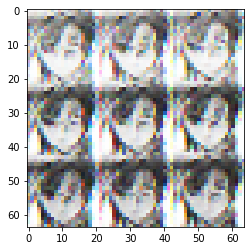

In [69]:
plt.imshow(immagine[])

In [75]:
z = torch.randn(25, NOISE_VECTOR_DIM, 1, 1).to(DEVICE)
generated_image = G(z)

In [78]:
generated_image = generated_image[None, :]

In [88]:
images.shape

torch.Size([25, 3, 64, 64])

In [82]:
for images in generated_image:
  print(images.shape)

torch.Size([25, 3, 64, 64])


In [ ]:
for images, _ in data_loader:
  print(images.shape)

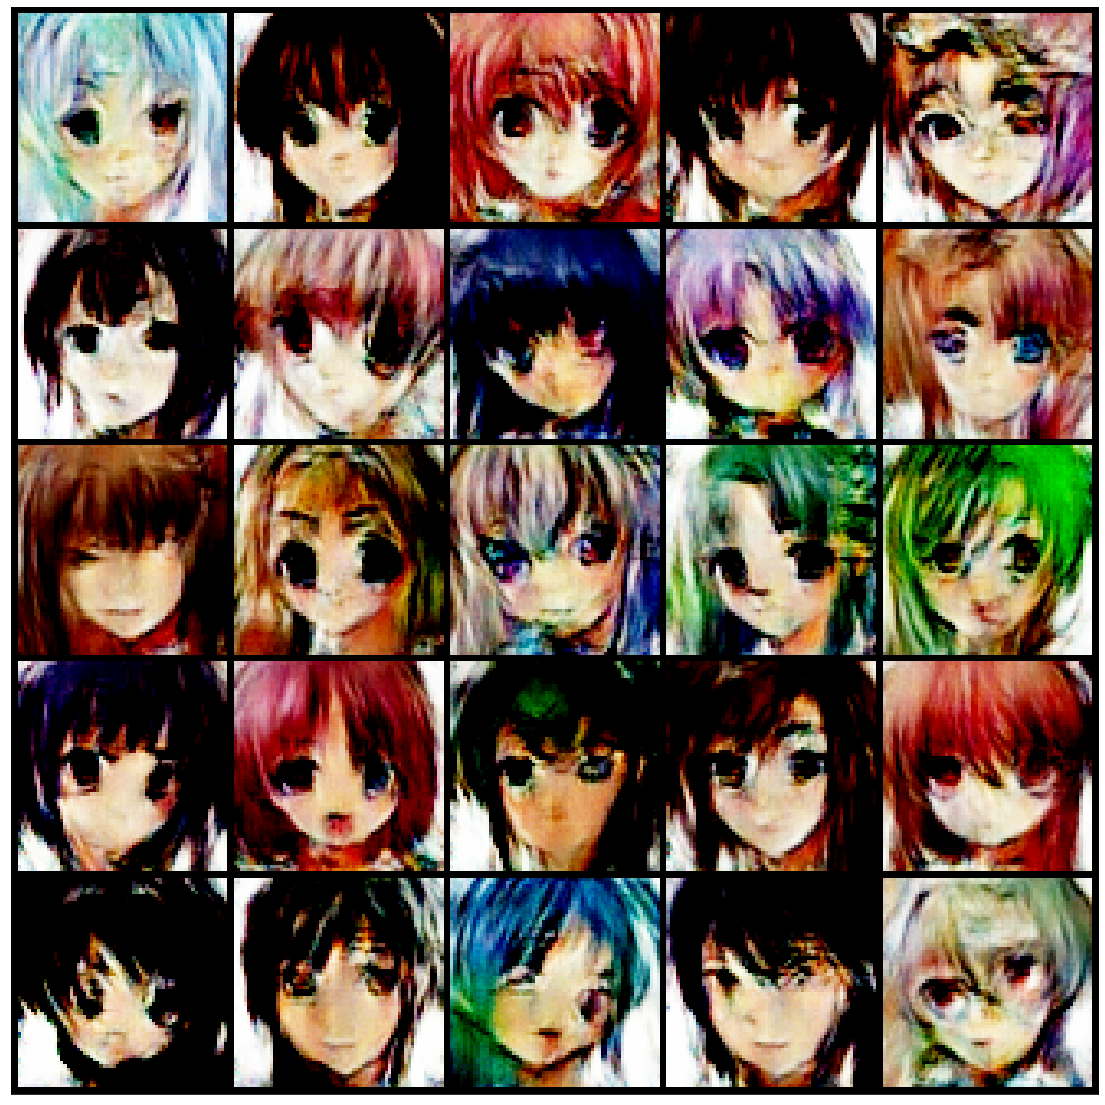

In [90]:
show_images(images.cpu())

In [80]:
show_batch(generated_image)

ValueError: ignored

In [16]:
def get_sample_images(G, num_samples):
  '''
  Generate num_samples noise vector from latent space and pass to Generator
  as input in order to get sample images.

  returns:
    num_samples generate images
  '''
  assert int(np.sqrt(num_samples)) * int(np.sqrt(num_samples)) == num_samples  , "num_samples square is not integer"

  z = torch.randn(num_samples, NOISE_VECTOR_DIM).to(DEVICE)  #z.shape = torch.Size([num_samples, 100])
  y_hat = G(z).view(num_samples, 3, 64, 64) # (100, 3, 64, 64)
  samples_img = y_hat.cpu().data.numpy()

  #Put generated samples in a matrix of size sqrt(num_samples) x sqrt(num_samples)
  #in order to plot all samples togheter
  samples_per_line = int(np.sqrt(num_samples))
  matrix_img = np.zeros([64 * samples_per_line, 64 * samples_per_line])
  for j in range(samples_per_line): 
    matrix_img[j*64:(j+1)*64] = np.concatenate([x for x in samples_img[j*samples_per_line:(j+1)*samples_per_line]], axis=-1)
      
  return matrix_img
    

def make_gif(frame_folder, duration):
  '''
  Make a gif from generated samples during the training in order to see
  the improvement of the generator.

  returns:
    save a gif on google drive directory
  '''
  a = [image for image in glob.glob(f"{frame_folder}/*.jpg")]
  imgs = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.jpg")]
  for i in range(len(imgs)):
    plt.imshow(imgs[i], cmap='gray')
    plt.axis('off')
    plt.title('epoch: {}'.format(int(i* 150/len(imgs))))
    plt.savefig(frame_folder + 'gif_dir/img_%d.jpg' % int(i* 150/len(imgs)))


  a = [image for image in glob.glob(f"{frame_folder + '/gif_dir'}/*.jpg")]
  frames = [Image.open(image) for image in glob.glob(f"{frame_folder + '/gif_dir'}/*.jpg")]
  print('frames: {}'.format(len(frames)))
  frame_one = frames[0]
  frame_one.save(PATH_DRIVE + "/training_improvements.gif", format="GIF",
              append_images=frames, save_all=True, duration=duration, loop=0)

In [84]:
def show_images(images):
  fig, ax = plt.subplots(figsize=(20, 20))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(images.detach(), nrow=5).permute(1, 2, 0))

def show_batch(dl):
  for images, _ in dl:
    show_images(images)
    break

### **Dataset loading and preparation**

In [6]:
BATCH_SIZE = 64
train_transform = transforms.Compose([transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
train_dataset = datasets.ImageFolder(root='dataset', transform=train_transform)
data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

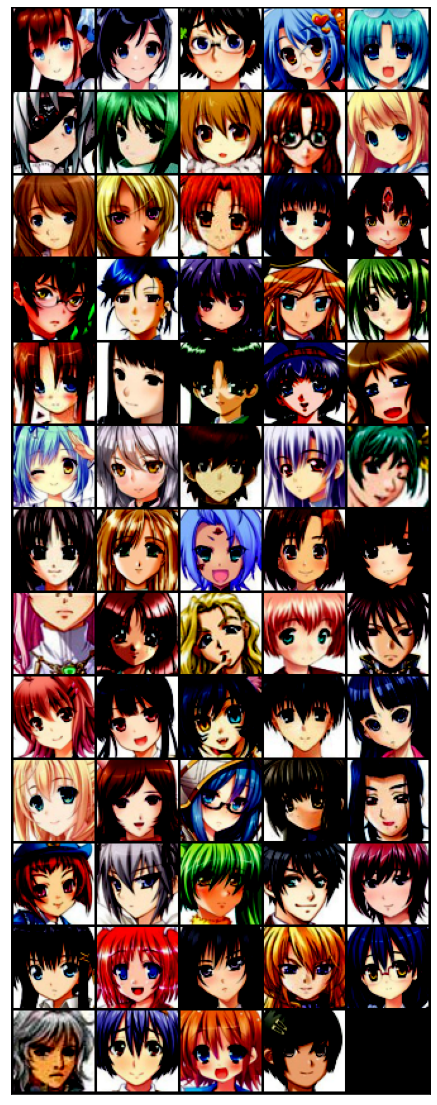

In [85]:
show_batch(data_loader)

In [6]:
# Generator Model Class Definition      
class Generator(nn.Module):

  def __init__(self, input_size=NOISE_VECTOR_DIM):
    super(Generator, self).__init__()
    
    self.model = nn.Sequential(
      # Block 1:input is Z, going into a convolution
      nn.ConvTranspose2d(input_size, 64 * 8, 4, 1, 0, bias=False),
      nn.BatchNorm2d(64 * 8),
      nn.LeakyReLU(0.2),

      # Block 2: (64 * 8) x 4 x 4
      nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(64 * 4),
      nn.LeakyReLU(0.2),

      # Block 3: (64 * 4) x 8 x 8
      nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(64 * 2),
      nn.LeakyReLU(0.2),

      # Block 4: (64 * 2) x 16 x 16
      nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
      nn.BatchNorm2d(64),
      nn.LeakyReLU(0.2),

      # Block 5: (64) x 32 x 32
      nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
      nn.Tanh()
      # Output: (3) x 64 x 64
  )

  def forward(self, noise_vector):
    generated_img = self.model(noise_vector)
    return generated_img

In [8]:
# Discriminator Model Class Definition
class Discriminator(nn.Module):
  def __init__(self, input_size=(3, 64, 64), num_classes=1):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
      # Block 1: (3) x 64 x 64
      nn.Conv2d(3, 64, 4, 2, 1, bias=False),
      nn.LeakyReLU(0.2, inplace=True),

      # Block 2: (64) x 32 x 32
      nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(64 * 2),
      nn.LeakyReLU(0.2, inplace=True),

      # Block 3: (64*2) x 16 x 16
      nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(64 * 4),
      nn.LeakyReLU(0.2, inplace=True),

      # Block 4: (64*4) x 8 x 8
      nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
      nn.BatchNorm2d(64 * 8),
      nn.LeakyReLU(0.2, inplace=True),

      # Block 5: (64*8) x 4 x 4
      nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
      nn.Sigmoid(),
      nn.Flatten()
      # Output: 1
  )

  def forward(self, input):
      output = self.model(input)
      return output

## **Training phase**

In [9]:
#Models creation
num_samples = 100
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

#Loss function
adversarial_loss  = nn.BCELoss()

#Optimizer
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [13]:
max_epoch = 4 # epochs for training
step = 0
step_frequency = 500 #frequency to save training samples in order to see G's improvements
n_critic = 1 # for training more k steps about Discriminator

D_loss_history = []
G_loss_history = []

D_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(BATCH_SIZE, 1).to(DEVICE) # Discriminator Label to fake


D_loss_plot, G_loss_plot = [], []
for epoch in tqdm(range(max_epoch), desc='DCGAN training'): 
  # D_loss_list, G_loss_list = [], []
  for index, (real_images, _) in enumerate(data_loader):
    # training D
    x = real_images.to(DEVICE)
    x_outputs = D(x)
    D_x_loss = adversarial_loss(x_outputs, D_labels)

    
    # real_target = real_target.unsqueeze(1)
    # fake_target = fake_target.unsqueeze(1)
    # D_real_loss = adversarial_loss(D(real_images), real_target)

    # print(discriminator(real_images))
    # noise vector sampled from a normal distribution
    z = torch.randn(BATCH_SIZE, NOISE_VECTOR_DIM, 1, 1).to(DEVICE)
    generated_image = G(z)
    z_outputs = D(generated_image)
    D_z_loss = adversarial_loss(z_outputs, D_fakes)
    D_loss = D_x_loss + D_z_loss


    D.zero_grad()
    D_loss.backward()
    D_optimizer.step()


    # D_real_loss.backward()

    # noise_vector = torch.randn(real_images.size(0), NOISE_VECTOR_DIM, 1, 1, device=DEVICE)  
    # noise_vector = noise_vector.to(DEVICE)

    # generated_image = G(noise_vector)
    # output = D(generated_image.detach())
    # D_fake_loss = adversarial_loss(output,  fake_target)


    # # train with fake
    # D_fake_loss.backward()

    # D_total_loss = D_real_loss + D_fake_loss
    # D_loss_list.append(D_total_loss)

    # #D_total_loss.backward()
    # D_optimizer.step()

    if step % n_critic == 0:
      # Training Generator
      z = torch.randn(BATCH_SIZE, NOISE_VECTOR_DIM, 1, 1).to(DEVICE)
      z_outputs = D(G(z))
      G_loss = adversarial_loss(z_outputs, D_labels)

      G.zero_grad()
      G_loss.backward()
      G_optimizer.step()


    if verbose:
      if step % 500 == 0:
        print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

    
    if step % step_frequency == 0:
      G.eval()
      # img = get_sample_images(G, num_samples)
      # imsave(PATH_DRIVE + '/samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), generated_image.data[:50], cmap='gray')
      save_image(generated_image.data[:25], PATH_DRIVE + '/samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), nrow=5, normalize=True)
      G.train()

    step += 1
    # print(step)

  D_loss_history.append(D_loss.item())
  G_loss_history.append(G_loss.item())
    
  torch.save(G.state_dict(), PATH_DRIVE + '/training_models/Generator/G_epoch_%d.pth' % (epoch))
  torch.save(D.state_dict(), PATH_DRIVE + '/training_models/Discriminator/D_epoch_%d.pth' % (epoch))

DCGAN training: 100%|██████████| 4/4 [08:30<00:00, 127.63s/it]


## **Post training operations**

### **Plotting Generator and Discriminator's losses**

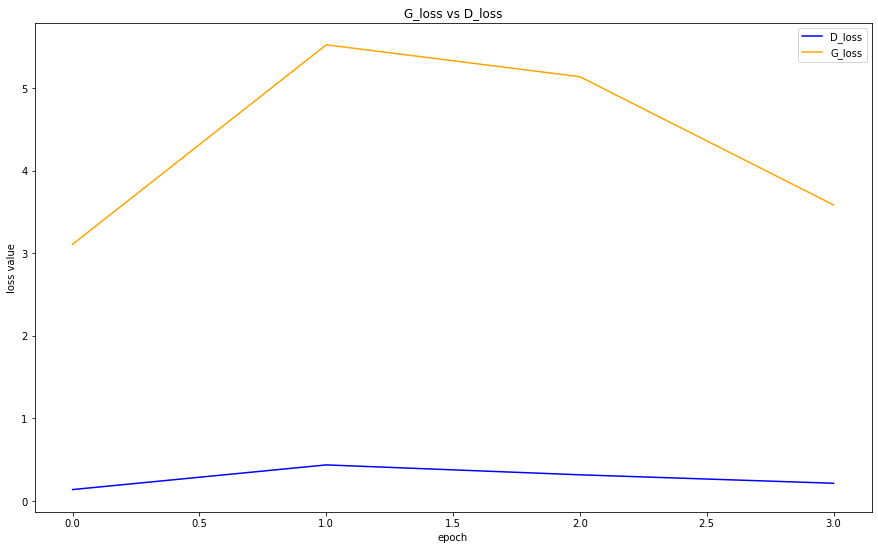

In [14]:
plt.figure(figsize=(15,9)) 
plt.plot(D_loss_history, color='blue', label='D_loss') #plot the data
plt.plot(G_loss_history, color='orange', label='G_loss') #plot the data
plt.ylabel('loss value') #set the label for y axis
plt.xlabel('epoch') #set the label for x-axis
plt.title("G_loss vs D_loss") #set the title of the graph
plt.legend()
plt.show() #display the graph

### **Plotting some sample images**

In [10]:
# generation to image
G.eval()
plt.figure(figsize=(8,8))
z = torch.randn(BATCH_SIZE, NOISE_VECTOR_DIM, 1, 1).to(DEVICE)
generated_image = G(z)
imshow(generated_image.data[:25].cpu())

NameError: ignored

<Figure size 576x576 with 0 Axes>

In [18]:
# Saving params
min_value = min(G_loss_history)
min_index = G_loss_history.index(min_value)
print(min_index)  #to see at which epoch the Generator has te lowest loss

# Saving models at last epoch of training
torch.save(D.state_dict(), PATH_DRIVE + '/training_models/Discriminator/Discriminator.pth')
torch.save(G.state_dict(), PATH_DRIVE + '/training_models/Generator/Generator.pth')

0


### **Loading model using pytorch**

In [11]:
G.load_state_dict(torch.load(PATH_DRIVE + '/training_models/Generator/Generator.pth'), strict=False)
G.eval()

RuntimeError: ignored

### **Making a gif to see Generator's improvement during training**

frames: 8


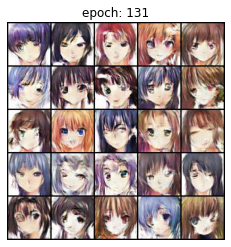

In [17]:
make_gif(PATH_DRIVE + '/samples/', 300)